In [211]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from urllib.request import urlopen
import wordcloud
from wordcloud import get_single_color_func
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JHCho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [212]:
lyrics_series = pd.read_csv('data/metadata/tracks_metadata.csv', encoding='cp949')['lyrics']
lyrics = ''.join(lyrics_series.str.lower().to_list())

In [215]:
def group_words_sentiment(words, threshold1=0.5, threshold2=0.2):
    vp=[];vn=[]
    p=[];n=[]
    neu=[]
    for text in words:
        sid = SentimentIntensityAnalyzer()
        scores = sid.polarity_scores(text)
        score = scores['compound']
    
        if score <= -threshold1: 
            vn.append(text)
        elif score >= threshold1: 
            vp.append(text)
        elif (score > -threshold1) & (score <= -threshold2): 
            n.append(text)
        elif (score < threshold1) & (score >= threshold2): 
            p.append(text)
        else: 
            neu.append(text)
    dict_ = dict(zip(['very_positive','positive','neutral','negative','very_negative'], [vp,p,neu,n,vn]))
    return dict_


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.
       Uses wordcloud.get_single_color_func
       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.
       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

In [218]:
# lyric cloud
def save_lyric_wordcloud(lyrics, output_path, figsize=(16,8), color_func=None):
    wc = wordcloud.WordCloud(max_words=300,
                             color_func=color_func,
                             width = 800,
                             height = 400,
                             min_word_length=3,
                             collocations=False,
                             repeat=True,
                             min_font_size=3,
                             background_color='white')
    lyric_img = wc.generate(lyrics).to_array()
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(lyric_img, interpolation="bilinear")
    ax.axis('off')
    fig.savefig(output_path)
    return wc

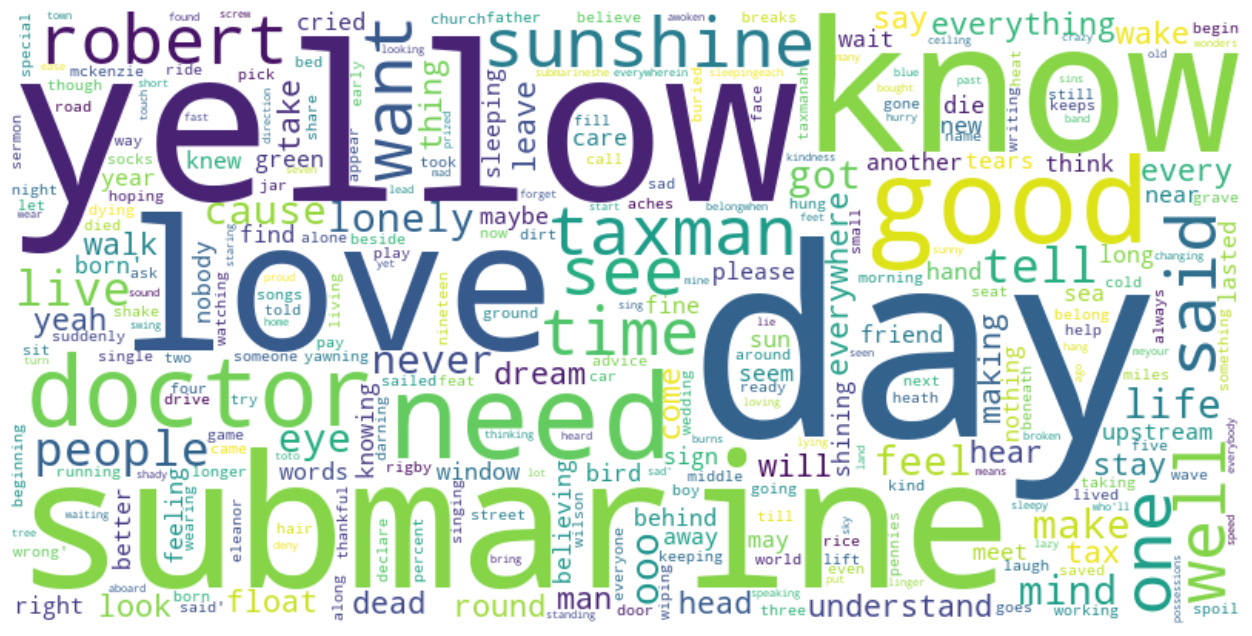

In [219]:
wc = save_lyric_wordcloud(lyrics, output_path="data/lyrics_wordcloud.jpg")

In [220]:
words = wc.words_.keys()
sentiments = group_words_sentiment(words,0.4,0.1)

In [225]:
color_to_words = {
    '#33FD1F': sentiments['very_positive'],
    '#A6FD1F': sentiments['positive'],
    '#FD981F': sentiments['negative'],
    '#E11F1F': sentiments['very_negative']}
default_color = 'grey'

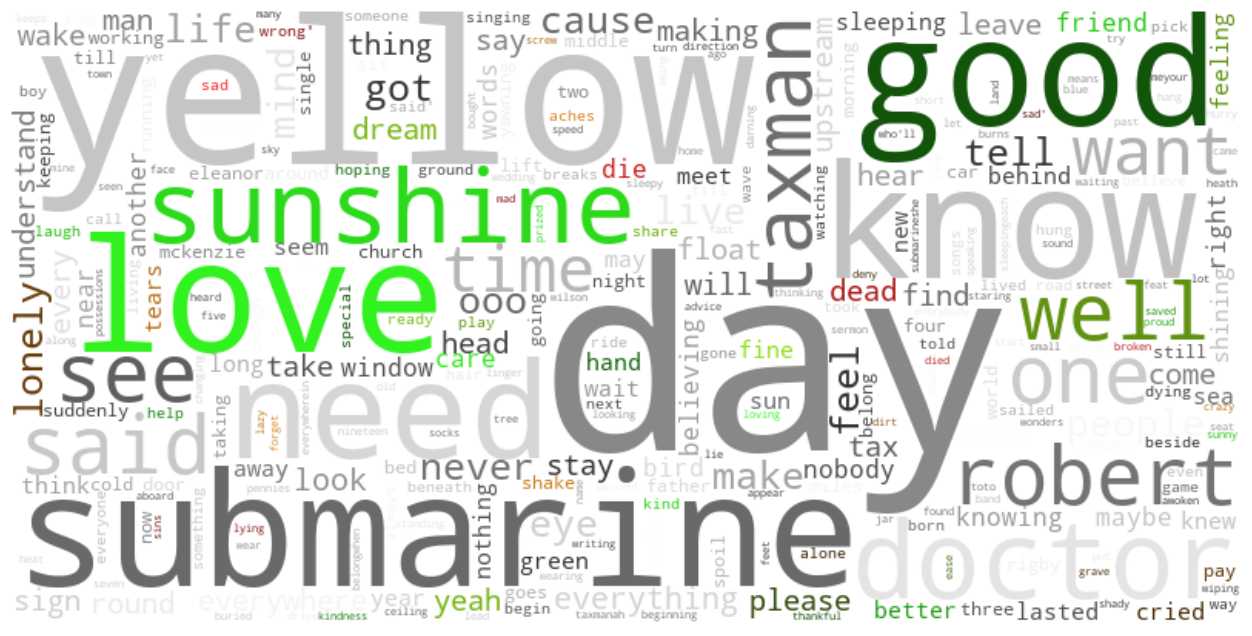

In [226]:
wc_senti = save_lyric_wordcloud(lyrics, output_path="data/lyrics_wordcloud_sentiments.jpg", 
                                color_func=GroupedColorFunc(color_to_words, default_color))